## Pooling Layer

- max_pooling
- GAP

#### ライブラリ

In [7]:
# オープンソース
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
import torchvision
from torchvision import transforms
from torch.nn import Conv2d
from torch.utils.data import DataLoader
# 自作
import utils

### Max Pooling

#### スクラッチ実装

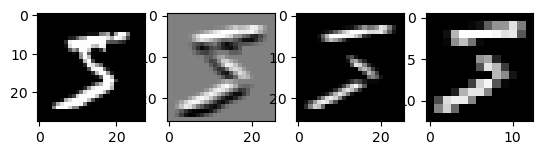

In [ ]:
# max_pooling
def max_pooling(X, kernel_size=2, stride=2):
    X_h, X_w = X.shape
    output_data = []
    for i in range(0, X_h - kernel_size + 1, stride):
        row = []
        for j in range(0, X_w - kernel_size + 1, stride):
            row.append(X[i:i+kernel_size, j:j+kernel_size].max().item())
        output_data.append(row)
    return torch.tensor(output_data)

# conv2d
def apply_filter(im, filter):
    im_h, im_w = im.shape
    f_h, f_w = filter.shape
    output_data = []
    for i in range(im_h - f_h + 1):
        row = []
        for j in range(im_w - f_w + 1):
            row.append((im[i:i+f_h, j:j+f_w] * filter).sum().item())
        output_data.append(row)
    return torch.tensor(output_data)

# relu
def relu(X):
    return torch.clamp(X, min=0)

# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])
train_dataset = torchvision.datasets.MNIST('~/data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST('~/data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

X, y = train_dataset[0]
X_ =  X[0, :, :]
# filter
top_edge_filter = torch.tensor([[-1, -1, -1],
                                [0, 0, 0],
                                [1, 1, 1]])
# conv
conv_out = apply_filter(X_, top_edge_filter)
# relu
relu_out = relu(conv_out)
# maxpooling
max_out = max_pooling(relu_out)
# 結果表示
fig, ax = plt.subplots(1, 4)
ax[0].imshow(X_, cmap='gray')
ax[1].imshow(conv_out, cmap='gray')
ax[2].imshow(relu_out, cmap='gray')
ax[3].imshow(max_out, cmap='gray')

#### PytorchのMaxPooling

In [ ]:
conv_model = nn.Sequential(
    # 1x28x28 -> 4x14x14
    nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 4x14x14 -> 8x7x7
    nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 8x7x7 -> 16x3x3
    nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 16x3x3 -> 32x1x1
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 32x1x1 -> 10x1x1
    nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1),
    # 10x1x1
    nn.Flatten()
)

In [6]:
class ConvModel(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2)
        X = F.relu(self.conv5(X))
        X = self.flatten(X)
        return X

### GAP

#### Global Average Layerのスクラッチ実装

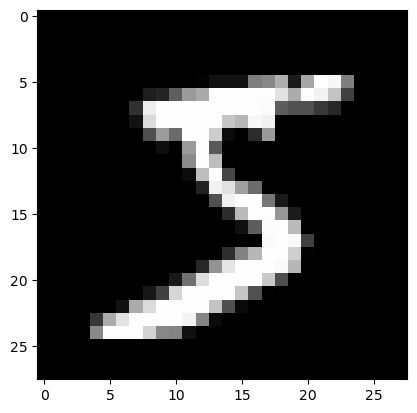

In [ ]:
class GlobalAveragePooling(nn.Module):
    def forward(self, X):
        return torch.mean(X, dim=(2, 3), keepdim=True)

#### PytorchでGAP層を実装

In [8]:
gap_layer = nn.AdaptiveAvgPool2d(1)   # 出力サイズを指定（直接的なGAPの実装はない）

#### GAP層をCNNモデルに追加

In [ ]:
conv_model = nn.Sequential(
    # 1x28x28 -> 4x14x14
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14 -> 8x7x7
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7 -> 16x3x3
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x3x3 -> 32x1x1
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),   # <- GAP
    # 32
    nn.Flatten(),
    # 10
    nn.Linear(32, 10)
)